In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


def set_seed(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

set_seed()

In [2]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

peptides_loaded = ('PXXDXXDXEDXPAALWX', 'EISLPSDFEHTIHVGFDAVTGEFT', 'ATVRTYSC', 'TENLYFQSGT', 'IPF', 'XSTGGXAPRKX', 'GKFYATFLIQEYFRKFKKRKEQG', 'DEEQQQALSSQMGF', 'APT', 'ARTKQTARXS', 'AGXGLVFR', 'YDESDE', 'HKLVQLLTTT', 'TWRVQRSQNPLKIRLTR', 'EEENIXSVPHDS', 'ENALLRYLLDK', 'EGEEY', 'GTYGVFTNAAYDPTP', 'PAWDETNL', 'NRLLLTG', 'VPKEVRVEPQK', 'EFEALSGDTMIEILDDDGIIQKISMEDLYQRLA', 'XFTNVSCTTSKECWSVCQRLHNTSRGKCMNKKCRCYS', 'ATLKYICAECSSKLSLSRTDAVRCKDCGHRILLKARTKRLVQFEARX', 'CEALKKALRRHRFLWQRRQRA', 'SCVDEILKETHSWPPPLTAIHTPCKTEPSKFPFPT', 'AALAALLAA', 'FANFCLMMI', 'AVLX', 'TFGSGEADCGLRPLFEKKSLEDKTERELLESYIDGR', 'RPRVLLKAPTLAEMEEM', 'KLVDVGLTSMDMVNLMLGVEITPENFX', 'FEPGRTRAPSLQVG', 'SPKGSISEETKQKLKSAILSAQSAAN', 'STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDD', 'APTYPPPLPP', 'VTPVSTAA', 'ARTXQTA', 'ITYDKGIQTDQ', 'SDQIVPEY', 'ARTXQTA', 'GSQTTAPDAPPDPTVDQVDDTSIVVRWSRP', 'DXELLTE', 'GGGGGGGGAASHQRVTPDWMLPLILGLYG', 'GCVLS', 'LLDDLFRKTKGTPCIYWLPLTPEAIAE', 'ESSDSQ', 'YPVEIPGVSNQFFLQTALNAVDILQMAVLEPVVADGVNSLRD', 'PTYKCPETFDAWYCLNDAHCFAVKIADLPVYSCECAIGFMGQRCEYKEX', 'EPEIPLSPRP', 'MFSSNRQKILERTEILNQEWKQRRIQPV', 'SLLMWITQCX', 'KLPVAQYSAPDGVEKSFAPTYLGQLRTQLTGLQDDINEFLTGRMELAKN', 'SRHKXLMFK', 'KAARXSAP', 'KGGAXRHR', 'KPKGALAVILVLTLTILVFWLGVYAVFFARGX', 'XXXLXLXPXG', 'KTLTGQQRLLVLRLRGX', 'GGAGHVPEYFVGIGTPISFYG', 'LEKSIVASDTX', 'KGAIIGLM', 'LTADAELQRLKNERHEEAELERLS', 'XXXXXXXXVXA')
receptors_loaded = ('GTFKDYVRDRADLNKDKPVIPAAALAGYTGSGPIQLWQFLLELLTDKSCQSFISWTGDGWEFKLSDPDEVARRWGKRKNKPKMNYEKLSRGLRYYYDKNIIHKTAGKRYVYRFVCDLQSLLGYTPEELHAMLDVK', 'MQAIKCVVVGDGAVGKTCLLISYTTNAFPGEYIPTVFDNYSANVMVDGKPVNLGLWDTAGQEDYDRLRPLSYPQTDVFLICFSLVSPASFENVRAKWYPEVRHHCPHTPILLVGTKLDLRDDKDTIERLRDKKLAPITYPQGLAMAREIGSVKYLECSALTQRGLKTVFDEAIRAVLGXX', 'AIIYTVELKRYGGPLGITISGTEEPFDPIIISSLTKGGLAERTGAIHIGDRILAINSSSLKGKPLSEAIHLLQMAGETVTLKIKKQ', 'PRDYNPISSTICHLTNESDGHTTSLYGIGFGPFIITNKHLFRRNNGTLLVQSLHGVFKVKNTTTLQQHLIDGRDIIIRPKDFPPFPQKLKFREPQREERICLVTTNFQTKSSSVSDTSCTFPSSDGIFWKHWIQTKDGQAGSPLVSTRDGFIVGIHSASNFTNTNNYFTSVPKNFELLTNQEAQQWVSGWRLNADSVLWGGHKVFSKP', 'EGWQRAFVLHSRPWSETSLMLDVFTEESGRVRLVAKGARSKRSTLKGALQPFTPLLLRFGGRGEVKTLRSAEAVSLALPLSGITLYSGLYINELLSRVLEYETRFSELFFDYLHCIQSLAGVTGTPEPALRRFELALLGHLGYGVNFTHCAGSGEPVDDTMTYRYREEKGFIASVVIDNKTFTGRQLKALNAREFPDADTLRAAKRFTRMALKPYLGGKPLKSRELFRQFMX', 'GELSKDGDLIVSMRILGKKRTKTWHKGTLIAIQTVGPGKKYKVKFDNKGKSLLSGNHIAYDYHPPADKLYVGSRVVAKYKDQVWLYAGIVAETPNVKNKLRFLIFFDDGYASYVTQSELYPICRPLKKTWEDIEDISCRDFIEEYVTAYPNRPMVLLKSGQLIKTEAEGTWWKSRVEEVDGSLVRILFLDDKRCEWIYRGSTRLEPMFSMKXXXXXXXXXXXXXXXXXXXXXXXXX', 'DTDTADQVMASFKILAGDKNYITMDELRRELPPDQAEYCIARMAPYTGPDSVPGALDYMSFSTALYGESDL', 'PVRVLPERIHLHELDPNPPGPESDYRTRWEIPIGLRETDLTPAHCHMHTNPHLLIFGAAKSGKTTIAHAIARAICARNSPQQVRFMLADYRSGLLDAVPDTHLLGAGAINRNSASLDEAVQALAVNLKKRLPPTDLTTAQLRSRSWWSGFDVVLLVDDWHMIVGAAGGMPPMAPLAPLLPAAADIGLHIIVTCQMSQAYKATMDKFVGAAFGSGAPTMFLSGEKQEFPSSEFKVKRRPPGQAFLVSPDGKEVIQAPYIEPPXX', 'ADQPSPTWGIDRIDQRNLPLDNNYHTDYDGSGVTAFVIDTGVLNTHNEFGGRASSGYDFIDNDYDATDCNGHGTHVAGTIGGSTYGVAKNVNVVGVRVLNCSGSGSNSGVIAGINWVKNNASGPAVANMSLGGGASQATDDAVNAAVAAGITFVVAAGNDNSNACNYSPARAADAITVGSTTSNDSRSSFSNYGTCLDIYAPGSSITSSWYTSNSATNTISGTSMASPHVAGVAALYLDENPNLSPAQVTNLLKTRATADKVTDAKTGSPNKLLFSLAX', 'RIRLPPFLKPGAAVEISSNESGFRGSWYGKVVAVPSSDSTTTKCEVEYTTLFFDKEGRKRLREVVDVGQLRPPAPAVSEREKRREVAVGDDVDAFYSDGWWEGTVTEVGDGRSVYFRASKEQIRFRRDELRFHREWVNGAWRPPI', 'LEWTWVEFTVDETVDVVVCMMYSPGEFYCHFLKDDALEKLDDLNQSLADYCAQFKAEIGRPCCAFFSGDGNWYRALVKEILPSGNVKVHFVDYGNVEEVTTDQLQAILPQFLLLPFQGMQCWLVDIQPPNKHWTKEATARFQACVVGLKLQARVVEITANGVGVELTDLSTPYPKIISDVLIREQLVLRCG', 'SRGRLWLQSPTGGPPPIFLPSDGQALVLGRGPLTQVTDRKCSRNQVELIADPESRTVAVKQLGVNPSTVGVHELKPGLSGSLSLGDVLYLVNGLYPLTLRWEELS', 'ESADLRALAKHLYDSYIKSFPLTKAKARAILTGKTTDKSPFVIYDMNSLMMGEDKKEVAIRIFQGCQFRSVEAVQEITEYAKSIPGFVNLDLNDQVTLLKYGVHEIIYTMLASLMNKDGVLISEGQGFMTREFLKSLRKPFGDFMEPKFEFAVKFNALELDDSDLAIFIAVIILSGDRPGLLNVKPIEDIQDNLLQALELQLKLNHPESSQLFAKLLQKMTDLRQIVTEHVQLLQVIKKTETDMSLHPLLQEIYKDLYX', 'ESEEEDKCKPMSYEEKRQLSLDINKLPGEKLGRVVHIIQSREPSLKNSNPDEIEIDFETLKPSTLRELERYVTSCLRKK', 'TAPPTNQWYHGKLDRTIAEERLRQAGKSGSYLIRESDRRPGSFVLSFLSQMNVVNHFRIIAMSGDYYIGGRRFSSLSDLIGYYSHVSSLLKGEKLLYPVAPPEP', 'KPEPTDEEWELIKTVTEAHVATNAQGSHWKQKRKFLPEDIGQAPIKVDLEAFSHFTKIITPAITRVVDFAKKLPMFCELPCEDQIILLKGCCMEIMSLRAAVRYDPESETLTLNGEMAVTRGQLKNGGLGVVSDAIFDLGMSLSSFNLDDTEVALLQAVLLMSSDRPGLACVERIEKYQDSFLLAFEHYINYRKHHVTHFWPKLLMKVTDLRMIGACHASRFLHMKVECPTELFPPLFLEVFEX', 'FHVNKSGFPIDSHTWERMWLHVAKVHPRGGEMVGAIRNAAFLAKPSIPQVPNYRLSMTIPDWLQAIQNYMKTLQYNHTGTQFFEIRKMRPLSGLMETAKEMTRESLPIKALEAVILGIYLTNGQPSIERFPISFKTYFSGNYFHHVVLGIYCNGYYGSLGMSRRAELMDKPLTFRTLSDLVFDFEDSYKKYLHTVKKVKIGLYVPHEPHSFQPIEWKQLVLNVSKMLRADIRKELEKYARDMRMKILKPAS', 'VPTEEVSLEVLLSNGQKVLVNVLTSDQTEDVLEAVAAKLDLPDDLIGYFSLFLVREKEDGAFSFVRKLQEFELPYVSVTSLRSQEYKIVLRKSYWDSAYDDDVMENRVGLNLLYAQTVSDIERGWILVTKEQHRQLKSLQEKVSKKEFLRLAQTLRHYGYLRFDACVADFPEKDCPVVVSAGNSELSLQLREGSFRVTRMRCWRVTSSVPLPSGGRGEVRLELAFEYLMSKDRLQWVTITSPQAIMMSICLQSMVDELMVKKS', 'LLIEPARIEEEELTLTILRQTGGLGISIAGGKGSTPYKGDDEGIFISRVSEEGPAARAGVRVGDKLLEVNGVALQGAEHHEAVEALRGAGTAVQMRVWRER', 'ENVQDLLLLDVAPLSLGLETAGGVMTALIKRNSTIPTKQTQIFTTYSDNQPGVLIQVYEGERAMTKDNNLLGRFELSGIPPAPRGVPQIEVTFDIDANGILNVTATDKSTGKANKITITNDKGRLSKEEIERMVQEAEKYKAEDEVQRERVSAKNALESYAFNMKSAVEDEGLKGKISEADKKKVLDKCQEVISWLDANTLAEKDEFEHKRKELEQVCNPIISGLYQG', 'SVLFPCKYASSGCEITLPHTEKADHEELCEFRPYSCPCPGASCKWQGSLDAVMPHLMHQHKSITTLQGEDIVFLATDINLPGAVDWVMMQSCFGFHFMLVLEKQEKYDGHQQFFAIVQLIGTRKQAENFAYRLELNGHRRRLTWEATPRSIHEGIATAIMNSDCLVFDTSIAQLFAENGNLGINVTISMCXX', 'DYKDDDDKMFKLNTKNIKVLTPSGFKSFSGIQKVYKPFYHHIIFDDGSEIKCSDNHSFGKDKIKASTIKVGDYLQGKKVLYNEIVEEGIYLYDLLNVGEDNLYYTNGIVSHACESRGK', 'ALHWRAAGAATVLLVIVLLAGSYLAVLAERGAPGAALISYPDALWWSVETATTVGYGDLYPVTLWGRCVAVVVMVAGITSYGLVFAAVATWFVGREQ', 'FEDESAPITAEDSWAVISAFFREKGLVSQQLDSFNQFVDYTLQDIICEDSTLIEISFGKIYVTKPMVNESDGVTHALYPQEARLRNLTYSSGLFVDVKKRTYEKVFIGRLPIMLRSKNCYLSEATESDLYKLKECPFDMGGYFIINGSEKVLIAQERSAGNIVQVFKKAAPSPISHVAEIRSALEKGSRFISTLQVKLYGREGSSARTIKATLPYIKQDIPIVIIFRALGIIPDGEILEHICYDVNDWQMLEMLKPCVEDGFVIQDRETALDFIGRRGTALGIKKEKRIQYAKDILQKEFLPHITQLEGFESRKAFFLGYMINRLLLCALDRKDQDDRDHFGKKRLDLAGPLLAQLFKTLFKKLTKDIFRYMQRTVELAINAKTITSGLKYALATGNWGAGVSQVLNRYTYSSTLSHLRRTNTPIAKPRQLHNTHWGLVCPAETPEGQACGLVKNLSLMSCISVGTDPMPIITFLSEWGMEPLEDYVPHQSPDATRVFVNGVWHGVHRNPARLMETLRTLRRKGDINPEVSMIRDIREKELKIFTDAGRVYRPLFIVEDDESLGHKELKVRKGHIAKLMATEYQDEYTWSSLLNEGLVEYIDAEEEESILIAMQPEDLEPDVDPAKRIRVSHHATTFTHCEIHPSMILGVAASIIPFPDHNQSPRNTYQSAMGKQAMGVFLTNYNVRMDTMANILYYPQKPLGTTRAMEYLKFRELPAGQNAIVAIACYSGYNQEDSMIMNQSSIDRGLFRSLFFRSYMDQEKKYGMSITETFEKPQRTNTLRMKHGTYDKLDDDGLIAPGVRVSGEDVIIGKTTPISSKRDASTPLRSTENGIVDQVLVTTNQDGLKFVKVRVRTTKIPQIGDKFASRHGQKGTIGITYRREDMPFTAEGIVPDLIINPHAIPSRMTVAHLIECLLSKVAALSGNEGDASPFTDITVEGISKLLREHGYQSRGFEVMYNGHTGKKLMAQIFFGPTYYQRLRHMVDDKIHARARGPGLRFGEMERDCMIAHGAASFLKERLMEASDAFRVHICGICGLMTVIAKLNHNQFECKGCDNKIDIYQIHIPYAAKLLFQELMAMNITPRLYTDRSRDFXX', 'MDGSGEQPRGGGPTSSEQIMKTGALLLQGFIQDRAGRMGGEAPELALDPVPQDASTKKLSECLKRIGDELDSNMELQRMIAAVDTDSPREVFFRVAADMFSDGNFNWGRVVALFYFASKLVLKALCTKVPELIRTIMGWTLDFLRERLLGWIQDQGGWDGLLSYFGTPTWQTVTIFVAGVLTASLTIWKKMG', 'LPDYLIKYIAIVSYEQRQNYKDDFNAEYDEYRALHARETVARRFIKLDAQRKRLSPGSKEYQNVHEEVLQEYQKIKQSSPNYHEEKYRCEYLHNKLAHIKRIGEFDQQQAESW', 'SLPSINALLQAEVLSRQITSPVSGINGDIRAKKIASIADVCESMKEQLLVLVEWAKYIPAFCELPLDDQVALLRAHAGEHLLLGATKRSMVFKDVLLLGNDYIVPRHCPELAEMSRVSIRILDELVLPFQELQIDDNEYAYLKAIIFFDPDAKGLSDPGKIKRLRSQVQVSLEDYINDRQYDSRGRFGELLLLLPTLQSITWQMIEQIQFIKLFGMAKIDNLLQEMLLGGX', 'GTHSLKYVYTGVSRGIDFPEFTAVGMVDDGQFMYFDSNSMKAVPKTEWIRQNEGADYWDRQTQVLIGAHQVFKDSIQIVMERFNQSKGVHTWQNMYGCELNDDGTTQGFYQYAYDGEDFVSLDKNTLTWTAANPQAVITKHKWEALAVAEQNKGYLENTCIEWLKKYVAYGKDTLERKVSPQVSLLQKDPSSPVTCHATGFYPSGVTITWQKNGQDHDEDVDLGELLPNEDGSFQRMSTLNVGPWKNNRFSCVVEHQDKTIRKTEDDIITNFD', 'SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDTVYCPRHVICTAEDMLNPNYEDLLIRKSNHSFLVQAGNVQLRVIGHSMQNCLLRLKVDTSNPKTPKYKFVRIQPGQTFSVLACYNGSPSGVYQCAMRPNHTIKGSFLNGSCGSVGFNIDYDCVSFCYMHHMELPTGVHAGTDLEGKFYGPFVDRQTAQAAGTDTTITLNVLAWLYAAVINGDRWFLNRFTTTLNDFNLVAMKYNYEPLTQDHVDILGPLSAQTGIAVLDMCAALKELLQNGMNGRTILGSTILEDEFTPFDVVRQCS', 'VEPVDPCFRANCEYQCQPLDQTSYLCVCAEGFAPIPHEPHRCQMFCNQTACPADCDPNTQASCECPEGYILDDGFICTDIDECENGGFCSGVCHNLPGTFECICGPDSALAGQIGTDCXX', 'EKDFQGMLEYKKEDEQKLVKNLILELKPRGVAVNLIPGLPAYILFMCVRHADYLNDDQKVRSLLTSTINSIKKVLKKRGDDFETVSFWLSNTCRFLHCLKQYSGEEGFMKHNTSRQNEHCLTNFDLAEYRQVLSDLAIQIYQQLVRVLENILQPMIVSGMLEHETTSSIADEGTYTLDSILRQLNSFHSVMCQHGMDPELIKQVVKQMFYIIGAITLNNLLLRKDMCSWSKGMQIRYNVSQLEEWLRDKNLMNSGAKETLEPLIQAAQLLQVKKKTDDDAEAICSMCNALTTAQIVKVLNLYTPVNEFEERVSVSFIRTIQMRLRDRKDSPQLLMDAKHIFPVTFPFNPSSLALETIQIPASLGLGFISRV', 'DPLDHLADKLFHSMGSDGVYARTALYESIVERLAALITSHREAGTEALRFPPVMSRAQLEKSGYLKSFPNLLGCVCGLHGTEREINAAVSRFDAGGDWTTSLSPADLVLSPAACYPVYPIAASRGPLPKGGLRFDVAADCFRREPSKHLDRLQSFRMREYVCIGTPDDVSDFRERWMVRAQAIARDLGLTFRVDYASDPFFGRVGQMKAVSQKQQQLKFELLIPLRSEEQPTACMSFNYHREHFGTTWGIQDANGEPAHTGCVAFGMDRLAVAMFHTHGTDLSAWPAKVRDILGLXX', 'STYSAEIRRTTMGVPHIKAGNWGSAGYGFGYVQAQDNLCTMADSFLTYRGERSRHLGGSAQLVYNSTLGRPRNIDSDFFHRHVISDEAVDRTMAAQPAKLLQMVEGFAAGYNRYVREAKAGGSAHAACRSEAWVQPITARDVWRRIYAANLAGGYSNFAEAIANAQPP', 'GRKKIQISRILDQRNRQVTFTKRKFGLMKKAYELSVLCDCEIALIIFNSANRLFQYASTDMDRVLLKYTEYSEPHESRTNTDILETLKRRGIG', 'QRRQLTPQQQQLVNQMKVAPIPKQLLQRIPNIPPNINTWQQVTALAQQKLLTPQDMEAAKEVYKIHQQLLFKARLQQQQAQ', 'MENDPNLFVALYDFVASGDNTLSITKGEKLRVLGYNHNGEWCEAQTKNGQGWVPSNYITPVN', 'THADSLNNLANIKREQGNIEEAVRLYRKALEVFPEFAAAHSNLASVLQQQGKLQEALMHYKEAIRISPTFADAYSNMGNTLKEMQDVQGALQCYTRAIQINPAFADAHSNLASIHKDSGNIPEAIASYRTALKLKPDFPDAYCNLAHCLQIVCDWTDYDERMKKLVSIVADQLEKNRLPSVHPHHSMLYPLSHGFRKAIAERHGNLCLDKINVLHKPPYEHPKDLKLSDGRLRVGYVSSDFGNHPTSHLMQSIPGMHNPDKFEVFCYALSPDDGTNFRVKVMAEANHFIDLSQIPCNGKAADRIHQDGIHILVNMNGYTKGARNELFALRPAPIQAMWLGYPGTSGALFMDYIITDQETSPAEVAEQYSEKLAYMPHTFFIGDHANMFPHLKKKAVIDFKSIYDNRIVLNGIDLKAFLDSLPDVKIVKMLNMPVIPMNTIAEAVIEMINRGQIQITINGFSISNGLATTQINNKAATGEEVPRTIIVTTRSQYGLPEDAIVYCNFNQLYKIDPSTLQMWANILKRVPNSVLWLLRFPAVGEPNIQQYAQNMGLPQNRIIFSPVAPKEEHVRRGQLADVCLDTPLCNGHTTGMDVLWAGTPMVTMPGETLASRVAASQLTCLGCLELIAKNRQEYEDIAVKLGTDLEYLKKVRGKVWKQRISSPLFNTKQYTMELERLYLQMWEHYAAGNKPDHMIX', 'AMSQDDDYLYCEKCQNFFIDSCPNHGPPLFVKDSMVDRGHPNHSVLSLPPGLRISPSGIPEAGLGVWNEASDLPVGLHFGPYEGQITEDEEAANSGYSWLITKGRNCYEYVDGQDESQANWMRYVNCARDDEEQNLVAFQYHRKIFYRTCRVIRPGCELLVWYGDEYGQELGIXX', 'STPIVKASDITDKLKEDILTISKDALDKYQLERDIAGTVKKQLDVKYGNTWHVIVGKNFGSYVTHEKGHFVYFYIGPLAFLVFKTA', 'RYSRLRVIAEIRHGDIFHSANIVSSIEFDRDDELFATAGVSRCIKVFDFSSVVNEPDMQCPIVEMSTRSKLSCLSWNKHEKNHIASSDYEGIVTVWDVTTRQSLMEYEEHEKRAWSVDFSRTEPSMLVSGSDDCKVKVWCTRQEASVINIDMKANICCVKYNPGSSNYIAVGSADHHIHYYDLRNISQPLHVFSGHKKAVSYVKFLSNNELASASTDSTLRLWDVKDNLPVRTFRGHTNEKNFVGLTVNSEYLACGSETNEVYVYHKEITRPVTSHRFGSPDMDDAEEEAGSYFISAVCWKSDSPTMLTANSQGTIKVLVLAA', 'SMYVIRDEWGNQIWICPGCNKPDDGSPMIGCDDCDDWYHWPCVGIMTAPPEEMQWFCPKCANKXX', 'MRGSNAPQPSHISKYILRWRPKNSVGRWKEATIPGHLNSYTIKGLKPGVVYEGQLISIQQYGHQEVTRFDFTTTSTSTPGSRSHHHHHH', 'QPLSGYPWFHGMLSRLKAAQLVLEGGTGSHGVFLVRQSETRRGECVLTFNFQGKAKHLRLSLNAAGQCRVQHLHFQSIFDMLEHFRVHPIPLESSDVVLVSYVPS', 'MEVLDLVTGPDSVTEIEAFLNPRMGQPPTPESLTEGGQYYGWSRGINLATSDTEDSPGNNTLPTWSMAKLQLPMLNEDLTCDTLQMWEAVSVKTEVVGSGSLLDVHGFNKPTDTVNTKGISTPVEGSQYHVFAVGGEPLDLQGLVTDARTKYKEEGVVTIKTITKKDMVNKDQVLNPISKAKLDKDGMYPVEIWHPDPAKNENTRYFGNYTGGTTTPPVLQFTNTLTTVLLDENGVGPLCKGEGLYLSCVDIMGWRVTRNYDVHHWRGLPRYFKITLRKRWVK', 'FLSLDSPTYVLYRDRAEWADIDPVPQNDGPSPVVQIIYSEKFRDVYDYFRAVLQRDERSERAFKLTRDAIELNAANYTVWHFRRVLLRSLQKDLQEEMNYIIAIIEEQPKNYQVWHHRRVLVEWLKDPSQELEFIADILNQDAKNYHAWQHRQWVIQEFRLWDNELQYVDQLLKEDVRNNSVWNQRHFVISNTTGYSDRAVLEREVQYTLEMIKLVPHNESAWNYLKGILQDRGLSRYPNLLNQLLDLQPSHSSPYLIAFLVDIYEDMLENQCDNKEDILNKALELCEILAKEKDTIRKEYWRYIGRSLQSKHSRESDIPASV', 'SMKPTKVHIGRLTRNVTKDHIMEIFSTYGKIKMIDMPVERMHPHLSKGYAYVEFENPDEAEKALKHMDGGQIDGQEITATAVLAPWPR', 'NEQEKELQRRLKRLYPAVDEQETPLPRSWSPKDKFSYIGLSQNNLRVHYKGHGKTPKDAASVRATHPIPAACGIYYFEVKIVSKGRDGYMGIGLSAQGVNMNRLPGWDKHSYGYHGDDGHSFCSSGTGQPYGPTFTTGDVIGCCVNLINNTCFYTKNGHSLGIAFTDLPPNLYPTVGLQTPGEVVDANFGQHPFVFDIEDYMREWRTKIX', 'NALQQWHHLFEAEGTKRSPQAQQHLQQLLRTGLPTRKHENWKYTPLEGLINSQFVSIAGEISPQQRDALALTLDSVRLVFVDGRYVPALSDATEGSGYEVSINDDRQGLPDAIQAEVFLHLTESLAQSVTHIAVKRGQRPAKPLLLMHITQGVAGEEVNTAHYRHHLDLAEGAEATVIEHFVSLNDARHFTGARFTINVAANAHLQHIKLAFENPLSHHFAHNDLLLAEDATAFSHSFLLGGAVLRHNTSTQLNGENSTLRINSLAMPVKNEVCDTRTWLEHNKGFCNSRQLHKTIVSDKGRAVFNGLINVAQHAIKTDGQMTNNNLLMGKLAEVDTKPQLEIYADDVKCSHGATVGRIDDEQIFYLRSRGINQQDAQQMIIYAFAAELTEALRDEGLKQQVLARIGQRLPGGA', 'DRDVRILYQVGDSEEDLPVCAPNAVCSKIDLYETPWIERQCRCPDGRTCPSSLGVEDGHTIADKTRHYKMCQPVHKLPVCKHFRDYTWTLTTAAELNVTEQIVHCRCPRNSVTYLTKREPIGNDSPGYRYLFACSPLTRLRCQRKQPCKLFTVRKRQEFLDEVNINSLCQCPKGHRCPSHHTQSGVIAGESFLEDNIQTYSGYCMANDXXXXXXXXX', 'ANSYVALYKFLPQENNDLALQPGDRIMLVDDSNEDWWKGKIGDRVGFFPANFVQRVRPGENVWRCCQPFSGNKEQGYMSLKENQICVGVGRSKDADGFIRVSSGKKRGLVPVDALTEI', 'YSFKCVNSLKEDHNQPLFGVQFNWHSKEGDPLVFATVGSNRVTLYECHSQGEIRLLQSYVDADADENFYTCAWTYDSNTSHPLLAVAGSRGIIRIINPITMQCIKHYVGHGNAINELKFHPRDPNLLLSVSKDHALRLWNIQTDTLVAIFGGVEGHRDEVLSADYDLLGEKIMSCGMDHSLKLWRINSKRMMNAIKESYDYNPNKTNRPFISQKIHFPDFSTRDIHRNYVDCVRWLGDLILSKSCENAIVCWKPGKMEDDIDKIKPSESNVTILGRFDYSQCDIWYMRFSMDFWQKMLALGNQVGKLYVWDLEVCTTLTHHKCGAAIRQTSFSRDSSILIAVCDDASIWRWDRLX', 'MKQEVTQIPAALSVPEGENLVLNCSFTDSAIYNLQWFRQDPGKGLTSLLLITPWQREQTSGRLNASLDKSSGSSTLYIAASQPGDSATYLCAVRPLLDGTYIPTFGRGTSLIVHPYIQNPDPAVYQLRDSKSSDKSVCLFTDFDSQTNVSQSKDSDVYITDKCVLDMRSMDFKSNSAVAWSNKSDFACANAFNN', 'SLDHTLELKIPFETERQATIATKVLSPDPILKPQDFQVDYSSEKNVMLVQFRSIDDRVLRVGVSSIIDSIKTIVEAMD', 'APHQEHVLGEPTLEGLAHYIREKNVRRILVLVGAGASVAAGIPDFRSPDTGIYANLGKYNLEDPTDAFSLTLLREKPEIFYSIARELNLWPGHFQPTAVHHFIRLLQDEGRLLRCCTQNIDGLEKAAGVSPELLVEAHGSFAAAACIECHTPFSIEQNYLEAMSGTVSRCSTCGGIVKPNVVFFGENLPDAFFDALHHDAPIAELVIIIGTSMQVHPFALLPCVVPKSVPRVVMNRERVGGLLFRFDVCRDVLFRGDCQENVVTLAEYLGLSEALAKRMRLSDX', 'MAKTRPGVASKIKTGRKELDSYTIKGTNKVVRAGDCVLMRPSDAGKPPYVARVEKIEADANVKVHCRWYYRPEESLGGRRQFHGAKELFLSDHFDVQSAHTIEGKCIVHTFKNYTRLENVGAEDYYCRFEYKAATGAFTPDRVAVYCKCEMPYNPDDLMVQCEGCKDWYHPACVGMTIEEAKKLDHFVCAECSSPADDVKVRLSXX', 'DEKLLKTIAESKYLVALTGAGVSAESGIPTFRGKDGLWNRYRPEELANPQAFAKDPEKVWKWYAWRMEKVFNAQPNKAHQAFAELERLGVLKCLITQNVDDLHERAGSRNVIHLHGSLRVVRCTSCNNSFEVESAPKIPPLPKCDKCGSLLRPGVVWFGEMLPPDVLDRAMREVERADVIIVAGTSAVVQPAASLPLIVKQRGGAIIEINPDETPLTPIADYSLRGKAGEVMDELVRHVRKALSX', 'SRVYEAYPEKKATLYFLVLGFLALIVGSLFGPFQALNYGNVDAYPLLKRLLPFVQSYYQGLTLHGVLNAIVFTQLFAQAIMVYLPARELNMRPNMGLMWLSWWMAFIGLVVAALPLLANEATVLYTFYPPLKGHWAFYLGASVFVLSTWVSIYIVLDLWRRWKAANPGKVTPLVTYMAVVFWLMWFLASLGLVLEAVLFLLPWSFGLVEGVDPLVARTLFWWTGHPIVYFWLLPAYAIIYTILPKQAGGKLVSDPMARLAFLLFLLLSTPVGFHHQFADPGIDPTWKMIHSVLTLFVAVPSLMTAFTVAASLEFAGRLRGGRGLFGWIRALPWDNPAFVAPVLGLLGFIPGGAGGIVNASFTLDYVVHNTAWVPGHFHLQVASLVTLTAMGSLYWLLPNLTGKPISDAQRRLGLAVVWLWFLGMMIMAVGLHWAGLLNVPRRAYIAQVPDAYPHAAVPMVFNVLAGIVLLVALLLFIYGLFSVLLSRERKPELAEAPLPFAEVISGPEDRRLVLAMDRIGFWFAVAAILVVLAYGPTLVQLFGHLNPVPGWRLWXXXXXXXXXXXXXXX', 'NTFFICETNQIMNEIEKAKGIILNRNMNDIWSALLIEVKKSNLIIKSTDRNIFFESTISIVSETDFKVLINASNFYDAVKAFNFYKKIKIVFNENNSKLEIMGEEYEDHLKEPTFSYEEIENYNYDMVNEDYTFGIEIKQKSFKKVINRIAFSAHLDESKNVLNGVYFSKDEDSKLLLVSTNGHRMSICKTEVIVEEDVNFIVPVKIFNFLKHLMSGEGMVKIKFSDKKFYVEFDNYKIACSLINGNYPDYKSIIPKEQKNKSLVSLGILKDRLARVNLYVDKSRKLVLTFSELQLKLLGEDLITGRKGEFFIKDPNYLYDGADEVMAINISYFVEAISVFETSKIEIQFNSGNVLKLSEPENFNFTHLIMPMSLG', 'RAVVPIESNPEVFTNFAHKLGLKNEWAYFDIYSLTEPELLAFLPRPVKAIVLLFPINDVIWFKQSVKNACGLYAILHSLSNNQSLLEPGSDLDNFLKSQSDTSSSKNRFDDVTTDQFVLNVIKENVQTFSTGQSEAPEATADTNLHYITYVEENGGIFELDGRNLSGPLYLGKSDPTATDLIEQELVRVRVASYMENANEEDVLNFAMLGLGPN', 'SAWGPAATIAARQSATGTKTDTPIQKVPQSISVVTAEEMALHQPKSVKEALSYTPGVSVGTRGASNTYDHLIIRGFAAEGQSQNNYLNGLKLQGNFYNDAVIDPYMLERAEIMRGPVSVLYGKSSPGGLLNMVSKRPTTEPLKEVQFKAGTDSLFQTGFDFSDSLDDDGVYSYRLTGLARSANAQQKGSEEQRYAIAPAFTWRPDDKTNFTFLSYFQNEPETGYYGWLPKEGTVEPLPNGKRLPTDFNEGAKNNTYSRNEKMVGYSFDHEFNDTFTVRQNLRFAENKTSQNSVYGYGVCSDPANAYSKQCAALAPADKGHYLARKYVVDDEKLQNFSVDTQLQSKFATGDIDHTLLTGVDFMRMRNDINAWFGYDDSVPLLNLYNNTDFDFNAKDPANSGPYRILNKQKQTGVYVQDQAQWDKVLVTLGGRYDWADQESLNRVAGTTDKRDDKQFTWRGGVNYLFDNGVTPYFSYSESFEPSSQVGKDGNIFAPSKGKQYEVGVKYVPEDRPIVVTGAVYNLTKTNNLMADPEGSFFSVEGGEIRARGVEIEAKAALSASVNVVGSYTYTDAEYTTDTTYKGNTPAQVPKHMASLWADYTFFDGPLSGLTLGTGGRYTGSSYGDPANSFKVGSYTVVDALVRYDLARVGMAGSNVALHVNNLFDREYVASCFNTYGCFWGAERQVVATATFRFXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX', 'MPPAIVVLIGPPGYVGKQYPITASDIVIGRSVESQVYIDDKSLSRSHAKFAVNGSEVSVIDLGSTNKTIVNGQVIPPLASCLLKNNDQIKTGNVIFKFLEKGS', 'NLYQFKNMIQCTVPSRSWADFADYGCYCGKGGSGTPVDDLDRCCQTHDNCYNEAENISGCRPYFKTYSYECTQGTLTCKGDNNACAASVCDCDRLAAICFAGAPYNDANYNIDLKARCNX', 'LSECKTGNGKNYRGTMSKTKNGITCQKWSSTSPHRPRFSPATHPSEGLEENYCRNPDNDPQGPWCYTTDPEKRYDYCDILECEEECMHCSGENYDGKISKTMSGLECQAWDSQSPHAHGYIPSKFPNKNLKKNYCRNPDRELRPWCFTTDPNKRWELCDIPRCTTX', 'KKKGYLRIVTTQGSLNIELHADMAPRACDSFLRLCAVKYFDDTIFHRCIRNFMIQGGRAELRQPQQSPRSISGFPGGAPFEDEFDNRLVHQGIGVLSMANDGKHSNLSEFFITFKSCEHLNNKHTIFGRVVGGLDVLRQWEKLETDKKDKPLKPPKVEEIIVFKNPFE')


class LoadedBatchDataset(Dataset):
    def __init__(self, peptides, receptors, num_duplicates):
        self.peptides = peptides
        self.receptors = receptors
        self.num_samples = len(peptides) * num_duplicates  # Artificially increase the dataset size

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Return data from the single batch
        return self.peptides[idx % len(self.peptides)], self.receptors[idx % len(self.receptors)]

num_duplicates = 1283  # size of original dataset
batch_size = 64

loaded_dataset = LoadedBatchDataset(peptides_loaded, receptors_loaded, num_duplicates)
train_loader_from_saved = DataLoader(loaded_dataset, batch_size=batch_size, shuffle=True)


# Create DataLoader
batch_size = 64  # or whatever batch size you want
train_loader = DataLoader(loaded_dataset, batch_size=batch_size, shuffle=True)


In [3]:
!pip install transformers

In [4]:
from transformers import EsmModel, EsmTokenizer
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
model = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
def masked_mean(h, mask):
    masked_h = h * mask.unsqueeze(-1)
    sum_masked_h = masked_h.sum(dim=1)
    count_non_masked = mask.sum(dim=1, keepdim=True).clamp(min=1)
    mean_masked_h = sum_masked_h / count_non_masked
    return mean_masked_h

class ExtendedCLIP(nn.Module):
    def __init__(self, input_dim, h1, h2, esm_type='protein'):
        super(ExtendedCLIP, self).__init__()

        # esm
        self.encoder = EsmModel.from_pretrained("facebook/esm2_t6_8M_UR50D")

        # freeze all parameters
        for param in self.encoder.parameters():
            param.requires_grad = False

        # h1 feedforward layers
        self.pep_amino_acid_ffn = nn.ModuleList()
        for _ in range(h1):
            self.pep_amino_acid_ffn.append(nn.Linear(input_dim, input_dim))
        self.rec_amino_acid_ffn = nn.ModuleList()
        for _ in range(h1):
            self.rec_amino_acid_ffn.append(nn.Linear(input_dim, input_dim))

        # h2 feedforward layers
        self.pep_embedding_ffn = nn.ModuleList()
        for _ in range(h2):
            self.pep_embedding_ffn.append(nn.Linear(input_dim, input_dim))
        self.rec_embedding_ffn = nn.ModuleList()
        for _ in range(h2):
            self.rec_embedding_ffn.append(nn.Linear(input_dim, input_dim))

        # temp scaling
        self.t = nn.Parameter(torch.tensor(1.0))

    def forward(self, pep_seq, rec_seq):
        # esm
        pep_embedding = self.encoder(**pep_seq).last_hidden_state
        rec_embedding = self.encoder(**rec_seq).last_hidden_state

        # h1 layers on each amino acid
        for layer in self.pep_amino_acid_ffn:
            pep_embedding = F.relu(layer(pep_embedding))
        for layer in self.rec_amino_acid_ffn:
            rec_embedding = F.relu(layer(rec_embedding))

        # avg embeddings over sequence length
        pep_avg_embedding = masked_mean(pep_embedding, pep_seq['attention_mask'])
        rec_avg_embedding = masked_mean(rec_embedding, rec_seq['attention_mask'])

        # h2 layers on avg embeddings
        for layer in self.pep_embedding_ffn:
            pep_avg_embedding = F.relu(layer(pep_avg_embedding))
        for layer in self.rec_embedding_ffn:
            rec_avg_embedding = F.relu(layer(rec_avg_embedding))

        # normalize embeddings
        pep_norm_embedding = pep_avg_embedding / pep_avg_embedding.norm(dim=-1, keepdim=True).clamp(min=1e-9)
        rec_norm_embedding = rec_avg_embedding / rec_avg_embedding.norm(dim=-1, keepdim=True).clamp(min=1e-9)

        return pep_norm_embedding, rec_norm_embedding

def compute_similarity_matrix(model, peptides, receptors):
    pep_norm_embedding, rec_norm_embedding = model(peptides, receptors)
    similarity_matrix = torch.mm(pep_norm_embedding, rec_norm_embedding.t())
    return similarity_matrix

def compute_loss(similarity_matrix, temperature):
    logits = similarity_matrix / temperature
    n = logits.size(0)
    exp_logits = torch.exp(logits)
    L_r = -torch.mean(torch.log(torch.exp(torch.diag(logits)) / torch.sum(exp_logits, dim=1)))
    L_p = -torch.mean(torch.log(torch.exp(torch.diag(logits)) / torch.sum(exp_logits, dim=0)))
    return (L_r + L_p) * 0.5

from torch.cuda.amp import autocast, GradScaler
import gc

def train(model, data_loader, optimizer, device, grad_acc_steps=4):
    scaler = GradScaler()

    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for batch_idx, (peptides, receptors) in enumerate(data_loader):
        print(batch_idx)
        with autocast():  # mixed precision context
            peptides = tokenizer(peptides, return_tensors='pt', padding=True).to(device)
            receptors = tokenizer(receptors, return_tensors='pt', padding=True).to(device)

            similarity_matrix = compute_similarity_matrix(model, peptides, receptors)
            loss = compute_loss(similarity_matrix, model.t)

            # mixed precision
            scaler.scale(loss).backward()

            # gradient accumulation
            if (batch_idx + 1) % grad_acc_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            total_loss += loss.item()

            del peptides
            del receptors
            del similarity_matrix
            del loss

    gc.collect()

    return total_loss / len(data_loader)

# def train(model, data_loader, optimizer, device):
#     model.train()
#     total_loss = 0
#     for batch_idx, (peptides, receptors) in enumerate(data_loader):
#         peptides = tokenizer(peptides, return_tensors='pt', padding=True).to(device)
#         receptors = tokenizer(receptors, return_tensors='pt', padding=True).to(device)
#         optimizer.zero_grad()
#         similarity_matrix = compute_similarity_matrix(model, peptides, receptors)
#         loss = compute_loss(similarity_matrix, model.t)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (peptides, receptors) in enumerate(data_loader):
            print(batch_idx)
            peptides = tokenizer(peptides, return_tensors='pt', padding=True).to(device)
            receptors = tokenizer(receptors, return_tensors='pt', padding=True).to(device)

            similarity_matrix = compute_similarity_matrix(model, peptides, receptors)
            loss = compute_loss(similarity_matrix, model.t)

            total_loss += loss.item()

            del peptides
            del receptors
            del similarity_matrix
            del loss

    gc.collect()

    return total_loss / len(data_loader)


In [6]:
# cleaning gpu ram
torch.cuda.empty_cache()

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed()
input_dim = 320
h1 = 2
h2 = 2
trained_model = ExtendedCLIP(input_dim, h1, h2).to(device)
optimizer = torch.optim.Adam(trained_model.parameters(), lr=1e-3)

num_epochs = 10
train_losses, val_losses = [], []

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Token indices sequence length is longer than the specified maximum sequence length for this model (1098 > 1024). Running this sequence through the model will result in indexing errors


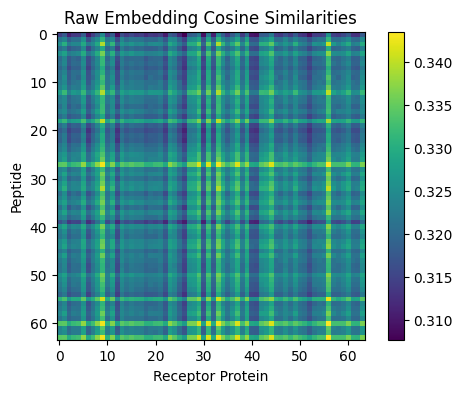

6342

In [8]:
curr_peptides, curr_receptors = next(iter(train_loader))
curr_peptides = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
curr_receptors = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)

similarity_matrix = compute_similarity_matrix(trained_model, curr_peptides, curr_receptors)
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(similarity_matrix_np, cmap='viridis')
plt.colorbar()
plt.title("Raw Embedding Cosine Similarities")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()

del curr_peptides
del curr_receptors
del similarity_matrix
del similarity_matrix_np
gc.collect()

In [9]:
for epoch in range(num_epochs):
    train_loss = train(trained_model, train_loader, optimizer, device)
    val_loss = evaluate(trained_model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()  # Clearing GPU cache after each epoch

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


0


OutOfMemoryError: ignored

In [ ]:
for epoch in range(num_epochs, 2*num_epochs):
    train_loss = train(trained_model, train_loader, optimizer, device)
    val_loss = evaluate(trained_model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()  # Clearing GPU cache after each epoch

    print(f"Epoch {epoch + 1}/{2*num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
for epoch in range(2*num_epochs, 3*num_epochs):
    train_loss = train(trained_model, train_loader, optimizer, device)
    val_loss = evaluate(trained_model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    torch.cuda.empty_cache()  # Clearing GPU cache after each epoch

    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# eval on test set
test_loss = evaluate(trained_model, test_loader, device)
print(f"Test Loss: {test_loss:.4f}")

In [ ]:
curr_peptides, curr_receptors = next(iter(train_loader))
curr_peptides = tokenizer(curr_peptides, return_tensors='pt', padding=True).to(device)
curr_receptors = tokenizer(curr_receptors, return_tensors='pt', padding=True).to(device)

similarity_matrix = compute_similarity_matrix(trained_model, curr_peptides, curr_receptors)
similarity_matrix_np = similarity_matrix.cpu().detach().numpy()

plt.figure(figsize=(6, 4))
plt.imshow(similarity_matrix_np, cmap='viridis')
plt.colorbar()
plt.title("Trained Embedding Cosine Similarities")
plt.xlabel("Receptor Protein")
plt.ylabel("Peptide")
plt.show()

del curr_peptides
del curr_receptors
del similarity_matrix
del similarity_matrix_np
gc.collect()

In [ ]:
torch.save(trained_model.state_dict(), 'temp.pth')

In [ ]:
trained_model = ExtendedCLIP(320, 2, 2)
trained_model.load_state_dict(torch.load('temp.pth'))
trained_model.to(device)